# 3 Crear Base de Datos

In [1]:
import mysql.connector 

db_connection = mysql.connector.connect(user="root",host="localhost",password="root")
cursor = db_connection.cursor()

In [2]:
#cursor.execute("DROP DATABASE Yapo;")
#cursor.execute("USE Yapo")

In [3]:
cursor.execute("CREATE DATABASE Yapo;")
cursor.execute("USE Yapo")

#tabla vendedor
cursor.execute("CREATE TABLE vendedor ("+
               "id_vendedor VARCHAR(130) PRIMARY KEY, nombre VARCHAR(100), ciudad VARCHAR(30), codigo_region VARCHAR(7), "+
               "nombre_region VARCHAR(30), "+
               "fecha_inscripcion DATE)")

#tabla anuncio
cursor.execute("CREATE TABLE anuncio (url VARCHAR(300) PRIMARY KEY, "+
               "titulo VARCHAR(200), descripcion MEDIUMTEXT, precio INT, moneda VARCHAR(2), fecha_publicacion DATE, categoria VARCHAR(50), "
               +"id_vendedor VARCHAR(130), FOREIGN KEY (id_vendedor) REFERENCES vendedor(id_vendedor))")

# 4 Scrapping

In [3]:
from urllib.request import urlopen as uReq
import urllib.request

from bs4 import BeautifulSoup as soup
from selenium import webdriver
import time

In [5]:
from selenium import webdriver
from webdriver_manager.opera import OperaDriverManager

browser = webdriver.Opera(executable_path=OperaDriverManager().install())

myUrl = 'https://www.yapo.cl/chile/todos_los_avisos?ca=12_s&l=0'

browser.get(myUrl)

[WDM] - Driver [/Users/mary/.wdm/drivers/operadriver/mac64/v.84.0.4147.89/operadriver_mac64/] found in cache


In [6]:
pageSoup = soup(browser.page_source, 'html.parser')

pages = pageSoup.find('span',  {'class', 'nohistory FloatRight'}).a['href']

In [7]:
index = pages.rfind('=')
print(index)
lastPage = int(pages[index+1:])
print(lastPage)
root_pages = pages[:index+1]
print(root_pages)

35
28220
https://www.yapo.cl/chile?ca=12_s&o=


In [8]:
import datetime

def convert_date(yapo_date):
    month=yapo_date.split(" ")[0]
    year=yapo_date.split(" ")[1]
    
    convert = {'Enero' : 1,
            'Febrero' : 2,
            'Marzo' : 3,
            'Abril' : 4,
            'Mayo' : 5,
            'Junio' : 6,
            'Julio' : 7,
            'Agosto' : 8,
            'Septiembre' : 9, 
            'Octubre' : 10,
            'Noviembre' : 11,
            'Diciembre' : 12
           }
    
    
    new_date=datetime.date(int(year), convert[month], 1) 

    return new_date

print(convert_date("Febrero 2020"))

2020-02-01


# 4 Completar DB

In [9]:
for i in range(lastPage):
    
    #recuperarmos la URL de la pagina corriente
    url = root_pages + str(i+1)
    
    #con Selenium, vamos en navegar en esta página
    browser.get(url)
    
    #empezamos el scrapping de la pagina corriente
    pageSoup = soup(browser.page_source, 'html.parser')
    
    #recuperamos todos los tags HTML que corresponden a la lista de anuncios en esta pagina
    links = pageSoup.findAll('td', {'class' : 'thumbs_subject'})
    
    #empezamos a iterar sobre cada anuncio
    for link in links:
        
        #todos los datos que necesitamos encontrar
        url, titulo, descripcion, precio, fecha_publicacion, categoria="","","",None,"", ""
        nombre, ciudad, codigo_region, nombre_region, fecha_inscripcion="","","","",""
        
        #Navegamos hacia la pagina del anuncio
        url=link.find('a',{'class':'title'})['href']
        print(url)
        browser.get(link.find('a',{'class':'title'})['href'])

        #RECUPERAMOS LA FECHA DE PUBLICACION DEL ANUNCIO          
        pageSoup = soup(browser.page_source, 'html.parser')
        if(pageSoup.find('time')):
            datetime_raw = pageSoup.find('time').attrs['datetime']
            date_publication_raw=datetime_raw.split("T")[0]
            date_publication_raw=  date_publication_raw.split("-")
            
            date_publication=datetime.date(int(date_publication_raw[0]), int(date_publication_raw[1]),
                                           int(date_publication_raw[2]))
            print("datetime:")
            print(date_publication)
        
        #RECUPERAMOS EL TITULO DEL ANUNCIO           
        pageSoup = soup(browser.page_source, 'html.parser')
        if(pageSoup.find('h1', {"id" : "da_subject"})):
            titulo = pageSoup.find('h1', {"id" : "da_subject"}).text.strip()
            print(titulo)
            
        #RECUPERAMOS LA DESCRIPCION DEL ANUNCIO
        if(pageSoup.find('div', {"class" : "description"})):
            try:
                descripcion = pageSoup.find('div', {"class" : "description"}).text.split(' ', 1)[1].strip().replace(u'\n', u' ')
            except:
                continue
                
        #RECUPERAMOS EL PRECIO DEL ANUNCIO
        if(pageSoup.find('div', {"class" : "price text-right"})):
            precio_raw = pageSoup.find('div', {"class" : "price text-right"}).text.strip().replace(u'\n', u' ').replace(u'\t', u'')
            precio_raw = precio_raw.split(" ")
            moneda = precio_raw[0]
            precio = precio_raw[1].split(",")[0].replace(u'.', u'')
            print("precio:"+precio)
            
        #RECUPERAMOS LA CATEGORIA DEL ANUNCIO
        if(pageSoup.find('div', {"class" : "breadcrumbs"})):
            categoria = pageSoup.find('div', {"class" : "breadcrumbs"}).find('a', {"id" : "breadcrumb_category"}).find('strong').text.strip().replace(u'\n', u' ')
            print(categoria)
            
        
        #RECUPERAMOS EL NOMBRE DEL VENDEDOR, SU FECHA DE INSCRIPCION Y SU LOCALIDAD
        if(pageSoup.find('aside', {"class" : "sidebar-right"})):
            aside = pageSoup.find('aside', {"class" : "sidebar-right"})
    
            #print(aside.find('seller-info'))
            
            #NOMBRE
            if(aside.find('seller-info')!=None):
                nombre=aside.find('seller-info').attrs['username']
            
                #FECHA DE INSCRIPCION
                fecha_inscripcion_raw=aside.find('seller-info').attrs['seniority']
                try:
                    fecha_inscripcion_raw=fecha_inscripcion_raw[len("En Yapo desde "):]
                    fecha_inscripcion=convert_date(fecha_inscripcion_raw)
                    print(fecha_inscripcion)
                except:
                    fecha_inscripcion=None
                    continue
                
                #LOCALIDAD
                localidad_raw=aside.find('seller-info').attrs['region']
            
                #print(localidad_raw)
            
                region_raw=localidad_raw.split(",")[0]
                ciudad_raw=localidad_raw.split(",")[1]
            
                codigo_region=region_raw.split(" ")[0]
                nombre_region=region_raw[len(codigo_region)+1:]
                ciudad=ciudad_raw[1:]
                
        # LLENAMOS LA BASE DE DATOS: TABLA VENDEDOR
        
        try:
            sql = "INSERT INTO vendedor (id_vendedor,nombre, ciudad, codigo_region, nombre_region, fecha_inscripcion) VALUES (%s,%s, %s, %s,%s,%s)"
            val = (nombre+"_"+codigo_region+"_"+ciudad,nombre, ciudad, codigo_region, nombre_region, fecha_inscripcion)
            cursor.execute(sql, val)
        except Exception as e1:
            print(e1)
            #continue
        
        # LLENAMOS LA BASE DE DATOS: TABLA ANUNCIO
        try:
            sql = "INSERT INTO anuncio (url, titulo, descripcion, precio, moneda, fecha_publicacion, categoria, id_vendedor) VALUES (%s, %s, %s,%s, %s, %s, %s, %s)"
            val = (url, titulo, descripcion, int(precio), moneda, date_publication, categoria, nombre+"_"+codigo_region+"_"+ciudad)
            cursor.execute(sql, val)
        except Exception as e2:
            print(e2)
            #continue
        
        cursor.execute("COMMIT")

https://www.yapo.cl/magallanes_antartica/vestuario-futura-mama-ninos/chaquetas_de_nina_74029184.htm?ca=14_s&first=1&oa=74029184&xsp=0
datetime:
2020-08-29
Chaquetas de niña
precio:10000
Vestuario futura mamá y niños
2015-12-01
https://www.yapo.cl/region_metropolitana/muebles/rack_74029183.htm?ca=15_s&oa=74029183&xsp=1
datetime:
2020-08-29
Rack
precio:145000
Muebles
2019-08-01
https://www.yapo.cl/region_metropolitana/vestuario-futura-mama-ninos/chaqueta_talla_8_74029182.htm?ca=15_s&oa=74029182&xsp=2
datetime:
2020-08-29
Chaqueta talla 8
precio:5000
Vestuario futura mamá y niños
2014-06-01
https://www.yapo.cl/region_metropolitana/autos/nissan_tiida_2014_full__74029181.htm?ca=15_s&oa=74029181&xsp=3
datetime:
2020-08-29
Nissan Tiida 2014 FULL
Autos, camionetas y 4x4
2018-03-01
int() argument must be a string, a bytes-like object or a number, not 'NoneType'
https://www.yapo.cl/arica_parinacota/celulares/huawei_mate_20_pro_gama_alta__nuevo__128gb_74029180.htm?ca=1_s&oa=74029180&xsp=4
datetim

datetime:
2020-08-29
Contratista de obras de construcción
Servicios
2016-02-01
int() argument must be a string, a bytes-like object or a number, not 'NoneType'
https://www.yapo.cl/aisen/salud-belleza/mascas_de_glitter_74029149.htm?ca=13_s&oa=74029149&xsp=37
datetime:
2020-08-29
Mascas de glitter
https://www.yapo.cl/valparaiso/servicios/construccion_fabricacion_remodelaciones_74029147.htm?ca=6_s&oa=74029147&xsp=38
datetime:
2020-08-29
Construcción-fabricación-remodelaciones
Servicios
2020-08-01
int() argument must be a string, a bytes-like object or a number, not 'NoneType'
https://www.yapo.cl/region_metropolitana/instrumentos_musicales/pack_guitarra_y_amplificador_74029148.htm?ca=15_s&oa=74029148&xsp=39
datetime:
2020-08-29
Pack guitarra y amplificador
precio:170000
Instrumentos musicales y accesorios
2015-06-01
https://www.yapo.cl/region_metropolitana/bolsos-bisuteria-accesorios/jockey_la_martina_74029146.htm?ca=15_s&oa=74029146&xsp=40
datetime:
2020-08-29
Jockey LA MARTINA
precio:200

datetime:
2020-08-29
Ludwig accent dorada/plata
precio:250000
Instrumentos musicales y accesorios
2016-08-01
https://www.yapo.cl/antofagasta/autos/mazda_3_skyactiv_2014_74029115.htm?ca=3_s&oa=74029115&xsp=23
datetime:
2020-08-29
Mazda 3 skyactiv 2014
precio:6200000
Autos, camionetas y 4x4
2016-12-01
https://www.yapo.cl/region_metropolitana/autos/fiat_strada_2013_74029114.htm?ca=15_s&oa=74029114&xsp=24
datetime:
2020-08-29
Fiat strada 2013
precio:1700000
Autos, camionetas y 4x4
2020-04-01
1062 (23000): Duplicate entry 'Tattersall Remates_Región_Estación Central' for key 'vendedor.PRIMARY'
https://www.yapo.cl/valparaiso/computadores/fuente_de_poder_cosari_80plus_cx500w_74029113.htm?ca=6_s&oa=74029113&xsp=25
datetime:
2020-08-29
Fuente de Poder Cosari 80plus CX500w
precio:35000
Computadores y accesorios
2020-08-01
https://www.yapo.cl/region_metropolitana/celulares/huawei_y7p__sin_uso_74029112.htm?ca=15_s&oa=74029112&xsp=26
datetime:
2020-08-29
Huawei Y7P, sin uso
precio:150000
Celulares, 

datetime:
2020-08-29
Zapatillas New Balance
precio:20000
Calzado
2020-07-01
1062 (23000): Duplicate entry 'CamilaXm_IX_Padre las Casas' for key 'vendedor.PRIMARY'
1062 (23000): Duplicate entry 'https://www.yapo.cl/araucania/calzado/zapatillas_new_balance_740' for key 'anuncio.PRIMARY'
https://www.yapo.cl/region_metropolitana/accesorios_vehiculos/grua_pluma_para_400_kilos_74029131.htm?ca=15_s&oa=74029131&xsp=6
datetime:
2020-08-29
Grúa pluma para 400 kilos
precio:450000
Accesorios y piezas para vehículos
2016-08-01
1062 (23000): Duplicate entry 'Casetas Chile Chile_Región_Buin' for key 'vendedor.PRIMARY'
1062 (23000): Duplicate entry 'https://www.yapo.cl/region_metropolitana/accesorios_vehiculos/gr' for key 'anuncio.PRIMARY'
https://www.yapo.cl/araucania/moda-vestuario/unifomes_clinicos_74029130.htm?ca=10_s&oa=74029130&xsp=7
datetime:
2020-08-29
Unifomes clinicos
precio:2000
Moda y vestuario
2014-04-01
1062 (23000): Duplicate entry 'Debora Fernandez zuñiga_IX_Temuco' for key 'vendedor.P

datetime:
2020-08-29
Fuente de Poder Cosari 80plus CX500w
precio:35000
Computadores y accesorios
2020-08-01
1062 (23000): Duplicate entry 'vicente_V_Petorca' for key 'vendedor.PRIMARY'
1062 (23000): Duplicate entry 'https://www.yapo.cl/valparaiso/computadores/fuente_de_poder_cosa' for key 'anuncio.PRIMARY'
https://www.yapo.cl/region_metropolitana/celulares/huawei_y7p__sin_uso_74029112.htm?ca=15_s&oa=74029112&xsp=26
datetime:
2020-08-29
Huawei Y7P, sin uso
precio:150000
Celulares, teléfonos y accesorios
2016-08-01
1062 (23000): Duplicate entry 'Freddy_Región_Maipú' for key 'vendedor.PRIMARY'
1062 (23000): Duplicate entry 'https://www.yapo.cl/region_metropolitana/celulares/huawei_y7p__s' for key 'anuncio.PRIMARY'
https://www.yapo.cl/biobio/accesorios_vehiculos/portalon_subaru_legacy_station_93_74029110.htm?ca=9_s&oa=74029110&xsp=27
datetime:
2020-08-29
Portalon subaru legacy station 93
precio:60000
Accesorios y piezas para vehículos
2013-12-01
1062 (23000): Duplicate entry 'roberto navar

datetime:
2020-08-29
Cuadro The Beatles!!!
precio:10000
Arte, antigüedades y colecciones
2016-11-01
https://www.yapo.cl/region_metropolitana/salud-belleza/perfumes_originales__74029085.htm?ca=15_s&oa=74029085&xsp=4
datetime:
2020-08-29
Perfumes originales
precio:25000
Salud y belleza
2019-01-01
https://www.yapo.cl/ohiggins/salud-belleza/afeitadora_para_bello_facial_74029084.htm?ca=7_s&oa=74029084&xsp=5
datetime:
2020-08-29
Afeitadora para bello facial
precio:4990
Salud y belleza
2015-07-01
https://www.yapo.cl/region_metropolitana/calzado/botin_marca_hispanita_74029083.htm?ca=15_s&oa=74029083&xsp=6
datetime:
2020-08-29
Botín marca HISPANITA
precio:50000
Calzado
2020-08-01
1062 (23000): Duplicate entry 'ventasosoriosyf_Región_La Reina' for key 'vendedor.PRIMARY'
https://www.yapo.cl/region_metropolitana/jardin_herramientas/frutales_74029082.htm?ca=15_s&oa=74029082&xsp=7
Frutales
precio:10000
Jardín, herramientas y exteriores
1292 (22007): Incorrect date value: '' for column 'fecha_inscrip

datetime:
2020-08-29
Nissan atlas 4x4
precio:7000000
Buses, camiones y furgones
2014-06-01
https://www.yapo.cl/region_metropolitana/libros_revistas/la_catadora_de_hitler_74029052.htm?ca=15_s&oa=74029052&xsp=38
datetime:
2020-08-29
La catadora de Hitler
precio:6000
Libros y revistas
2017-08-01
1062 (23000): Duplicate entry 'Daniela González _Región_Pudahuel' for key 'vendedor.PRIMARY'
https://www.yapo.cl/biobio/arrendar/busco_casa_74029051.htm?ca=9_s&oa=74029051&xsp=39
datetime:
2020-08-29
busco casa
precio:200000
Arriendo - Casa
https://www.yapo.cl/biobio/otros_productos/locos__pulpo_y_curanto_cocido_y_en_conserva_74029050.htm?ca=9_s&oa=74029050&xsp=40
datetime:
2020-08-29
Locos, pulpo y curanto cocido y en conserva
precio:20000
Otros productos
2016-08-01
https://www.yapo.cl/araucania/arrendar/busco_casa_en_angol_74029049.htm?ca=10_s&oa=74029049&xsp=41
datetime:
2020-08-29
Busco casa en angol
precio:300000
Arriendo - Casa
2020-08-01
https://www.yapo.cl/region_metropolitana/libros_revis

datetime:
2020-08-29
Nintendo switch
precio:370000
Consolas, videojuegos y accesorios
2016-03-01
https://www.yapo.cl/magallanes_antartica/celulares/algun_celular__74029021.htm?ca=14_s&oa=74029021&xsp=23
datetime:
2020-08-29
Algún celular?
precio:150000
Celulares, teléfonos y accesorios
2017-07-01
https://www.yapo.cl/los_rios/celulares/samsung_a50_74029020.htm?ca=11_s&oa=74029020&xsp=24
datetime:
2020-08-29
Samsung A50
Celulares, teléfonos y accesorios
2017-02-01
int() argument must be a string, a bytes-like object or a number, not 'NoneType'
https://www.yapo.cl/valparaiso/comprar/quipue_parcela_5_500_m2_con_casa_de_700_m2_74029019.htm?ca=6_s&oa=74029019&xsp=25
datetime:
2020-08-29
Quipue Parcela 5.500 m2 Con Casa de 700 m2
precio:339000000
Vendo - Casa
2017-03-01
https://www.yapo.cl/ohiggins/accesorios_vehiculos/lunetas_laterales_corsa_2005_74029018.htm?ca=7_s&oa=74029018&xsp=26
datetime:
2020-08-29
Lunetas laterales corsa 2005
precio:20000
Accesorios y piezas para vehículos
2020-05-01

datetime:
2020-08-29
Placa madre Intel de 8va y 9na NO PERMUTO
precio:120000
Computadores y accesorios
2013-12-01
https://www.yapo.cl/antofagasta/television_camaras/equipo_sony_74028992.htm?ca=3_s&oa=74028992&xsp=6
datetime:
2020-08-29
Equipo Sony
precio:400000
Audio, TV, video y fotografía
2016-08-01
https://www.yapo.cl/region_metropolitana/celulares/iphone_xr_red_128gb_prepago_74028991.htm?ca=15_s&oa=74028991&xsp=7
datetime:
2020-08-29
IPhone XR RED 128gb prepago
Celulares, teléfonos y accesorios
2016-05-01
int() argument must be a string, a bytes-like object or a number, not 'NoneType'
https://www.yapo.cl/region_metropolitana/camiones_furgones/hyundai_h1_2005_furgon_escolar_74028990.htm?ca=15_s&oa=74028990&xsp=8
datetime:
2020-08-29
Hyundai h1 2005 furgón escolar
precio:4650000
Buses, camiones y furgones
2014-04-01
https://www.yapo.cl/region_metropolitana/libros_revistas/saga_los_mitos_me_tienen_gordo_74028989.htm?ca=15_s&oa=74028989&xsp=9
datetime:
2020-08-29
Saga los mitos me tien

datetime:
2020-08-29
Mesa de madera grande
precio:70000
Muebles
2016-08-01
https://www.yapo.cl/region_metropolitana/moda-vestuario/chaqueta___abrigo_74028964.htm?ca=15_s&oa=74028964&xsp=41
datetime:
2020-08-29
Chaqueta / Abrigo
precio:8000
Moda y vestuario
2014-08-01
1062 (23000): Duplicate entry 'Montserrat Fonseca Llach_Región_Santiago' for key 'vendedor.PRIMARY'
https://www.yapo.cl/region_metropolitana/bicicletas_ciclismo/merida_ninety_nine_3000_74028963.htm?ca=15_s&oa=74028963&xsp=42
datetime:
2020-08-29
Merida Ninety-nine 3000
precio:1300000
Bicicletas, ciclismo y accesorios
2019-04-01
https://www.yapo.cl/araucania/moda-vestuario/blusas__74028962.htm?ca=10_s&oa=74028962&xsp=43
datetime:
2020-08-29
Blusas
precio:1000
Moda y vestuario
2019-09-01
1062 (23000): Duplicate entry 'Bazar Y Accesorios Para La Familia _IX_Padre las Casas' for key 'vendedor.PRIMARY'
https://www.yapo.cl/coquimbo/autos/suzuki_swift_1_2_at_gl_ac__74028961.htm?ca=5_s&oa=74028961&xsp=44
datetime:
2020-08-29
SUZUK

datetime:
2020-08-29
Alargador
precio:2500
Negocios, maquinaria y construcción
2014-08-01
1062 (23000): Duplicate entry 'alejandro flores ravanal_Región_San Joaquín' for key 'vendedor.PRIMARY'
https://www.yapo.cl/valparaiso/consolas_videojuegos/7_000_74028929.htm?ca=6_s&oa=74028929&xsp=26
datetime:
2020-08-29
7.000
precio:7000
Consolas, videojuegos y accesorios
2019-09-01
1062 (23000): Duplicate entry 'Tito_V_Viña del Mar' for key 'vendedor.PRIMARY'
https://www.yapo.cl/antofagasta/ofertas_de_empleo/conductor_rampla_74013626.htm?ca=3_s&oa=74013626&xsp=27
datetime:
2020-08-29
Conductor rampla
Ofertas de empleo
2020-08-01
int() argument must be a string, a bytes-like object or a number, not 'NoneType'
https://www.yapo.cl/region_metropolitana/negocios_maquinaria_construccion/bolsa_para_residuos_biologicos_peligrosos_73893533.htm?ca=15_s&oa=73893533&xsp=28
datetime:
2020-08-29
Bolsa para residuos biologicos peligrosos
Negocios, maquinaria y construcción
2020-06-01
int() argument must be a s

datetime:
2020-08-29
Parlante Titan 12
Audio, TV, video y fotografía
2016-07-01
int() argument must be a string, a bytes-like object or a number, not 'NoneType'
https://www.yapo.cl/region_metropolitana/servicios/me_ofrezco_como_administrador_de_condominios_74028901.htm?ca=15_s&oa=74028901&xsp=9
datetime:
2020-08-29
Me ofrezco como Administrador de Condominios
precio:400000
Servicios
2016-07-01
https://www.yapo.cl/region_metropolitana/jardin_herramientas/caja_para_herramientas_de_19___bauker_74028900.htm?ca=15_s&oa=74028900&xsp=10
datetime:
2020-08-29
Caja para herramientas de 19'' Bauker
precio:15000
Jardín, herramientas y exteriores
2020-01-01
https://www.yapo.cl/region_metropolitana/computadores/macbook_air_2017_13_3___core_i5__8gb_ram__128_ssd_74028899.htm?ca=15_s&oa=74028899&xsp=11
datetime:
2020-08-29
MacBook Air 2017 13.3", Core i5, 8GB RAM, 128 SSD
precio:680000
Computadores y accesorios
2016-03-01
https://www.yapo.cl/region_metropolitana/television_camaras/amplificador_marantz_

In [4]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas import DataFrame
import pandas as pd

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(12,6))

%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

UsageError: Line magic function `%%javascript` not found.


# 5 Consultas

In [11]:
#¿Cuál es el precio promedio de los anuncios por categoría?

sql = "SELECT categoria, avg(precio) FROM anuncio WHERE moneda=\"$\" GROUP BY categoria ORDER BY avg(precio) DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1

,categoria,avg(precio)
0,Vendo - Terreno,152000000.0000
1,Vendo - Casa,124987125.0000
2,"Autos, camionetas y 4x4",5301200.0000
3,"Buses, camiones y furgones",3937500.0000
4,Motos,2107500.0000
5,"Bicicletas, ciclismo y accesorios",1300000.0000
6,Busco empleo,800000.0000
7,Arriendo - Comercial e industrial,500000.0000
8,Arriendo - Departamento,385000.0000
9,Muebles,315666.6667


In [12]:
#¿Cuál es el número de anuncios por vendedor?

sql = "SELECT id_vendedor, nombre, count(*) as_nb_anuncios FROM anuncio JOIN vendedor USING (id_vendedor)  GROUP BY id_vendedor, nombre ORDER BY count(*) DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1

,id_vendedor,nombre,as_nb_anuncios
0,Daniela González _Región_Pudahuel,Daniela González,12
1,Pablo_VIII_Concepción,Pablo,7
2,roberto navarro_VIII_Concepción,roberto navarro,5
3,alejandro flores ravanal_Región_San Joaquín,alejandro flores ravanal,4
4,Tattersall Remates_Región_Estación Central,Tattersall Remates,4
...,...,...,...
205,victor manuel san martin hormazabal_XV_Arica,victor manuel san martin hormazabal,1
206,Victor_Región_La Granja,Victor,1
207,Vizcachas Propiedades_V_Quilpué,Vizcachas Propiedades,1
208,Wilma Ortega_II_Antofagasta,Wilma Ortega,1


In [13]:
#¿Cuál es el precio promedio de los anuncios según el día de la semana (lunes, martes, miercoles, etc.), por categoria?
sql = "select DAYOFWEEK(fecha_publicacion) as dia,categoria, avg(precio) from anuncio where moneda=\"$\" group by dia, categoria order by avg(precio) desc;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1

,dia,categoria,avg(precio)
0,7,Vendo - Terreno,152000000.0000
1,7,Vendo - Casa,124987125.0000
2,7,"Autos, camionetas y 4x4",5301200.0000
3,7,"Buses, camiones y furgones",3937500.0000
4,7,Motos,2107500.0000
5,7,"Bicicletas, ciclismo y accesorios",1300000.0000
6,7,Busco empleo,800000.0000
7,7,Arriendo - Comercial e industrial,500000.0000
8,7,Arriendo - Departamento,385000.0000
9,7,Muebles,315666.6667


In [14]:
#Insertar columna "perfil"

sql = "ALTER TABLE vendedor ADD perfil VARCHAR(10);"
cursor.execute(sql)

In [15]:
sql = "UPDATE vendedor SET perfil=\"Personal\";"
cursor.execute(sql)
cursor.execute("COMMIT")

In [16]:
sql = "SELECT id_vendedor FROM anuncio JOIN vendedor USING (id_vendedor)  GROUP BY id_vendedor HAVING count(*) >= 5 ORDER BY count(*) DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
#print(df1[:5])

for index,row in df1.iterrows():
    id_vendedor=row[0]
    
    sql = "UPDATE vendedor SET perfil=\"Pro\" WHERE id_vendedor=\""+id_vendedor+"\";"
    cursor.execute(sql)

cursor.execute("COMMIT")

In [17]:
#¿Cuál es el número de vendedores por tipo de perfil?
sql = "SELECT perfil, count(*) as vendedores FROM vendedor GROUP BY perfil;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1

,perfil,vendedores
0,Personal,247
1,Pro,3


# 6 Visualización

In [5]:
shp_path = "./cl_regiones_geo/cl_regiones_geo.shp"
sf = shp.Reader(shp_path, encoding="ISO8859-1")

In [6]:
len(sf.shapes())

15

In [7]:
sf.records()[2]

Record #2: ['02', 'Antofagasta']

In [8]:
sf.records()[1][1]

'Tarapaca'

In [9]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [10]:
df = read_shapefile(sf)
df.shape

(15, 3)

In [11]:
df.sample(15)

,ID_2002,NOMBRE,coords
12,10,Los Lagos,"[(-73.720279, -40.247128), (-73.718843, -40.24..."
11,14,Los Rios,"[(-71.967833, -40.63312), (-71.971205, -40.634..."
13,11,Aisen del Gral. Carlos Ibañez del Campo,"[(-72.737018, -43.829555), (-72.738551, -43.82..."
4,04,Coquimbo,"[(-69.952308, -29.503367), (-69.951567, -29.50..."
10,09,La Araucania,"[(-71.044287, -38.123172), (-71.029341, -38.13..."
8,07,Maule,"[(-70.363785, -35.003876), (-70.364762, -35.00..."
1,01,Tarapaca,"[(-70.286169, -19.228974), (-70.130959, -19.15..."
2,02,Antofagasta,"[(-68.481222, -20.945989), (-68.480813, -20.94..."
5,05,Valparaiso,"[(-70.319802, -32.274733), (-70.314426, -32.27..."
9,08,Biobio,"[(-73.684488, -37.367238), (-73.684134, -37.36..."


In [12]:
df[df.NOMBRE == 'Los Rios']

,ID_2002,NOMBRE,coords
11,14,Los Rios,"[(-71.967833, -40.63312), (-71.971205, -40.634..."


In [13]:
def calc_color(data, color=None):
        if color   == 1: 
            color_sq =  ['#dadaebFF','#bcbddcF0','#9e9ac8F0',
                        '#807dbaF0','#6a51a3F0','#54278fF0']; 
            colors = 'Purples';
        elif color == 2: 
            color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494']; 
            colors = 'YlGnBu';
        elif color == 3: 
            color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525']; 
            colors = 'Greys';
        elif color == 9: 
            color_sq = ['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:            
            color_sq = ['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']; 
            colors = 'YlOrBr';
        
        new_data, bins = pd.qcut(data, 6, retbins=True, labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;

In [14]:
def plot_regiones_data(sf, title, regiones, data=None, 
                      color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    df = read_shapefile(sf)
    region_id = []
    for i in regiones:
        #print(i)
        id = df[df.NOMBRE == i].index.get_values()[0]
        region_id.append(id)
        
        
    y_lim = (-41,-17) # latitude 
    x_lim = (-76, -66) # longitude
    
    plot_map_fill_multiples_ids_tone(sf, title, region_id, 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = x_lim, 
                                     y_lim = y_lim, 
                                     figsize = (10,25));

In [15]:
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (5,12)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in comuna:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_ton[comuna.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, id, fontsize=10)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [16]:
from pandas import DataFrame
#¿Cuál es el número de anuncios Yapo.cl en cada región de Chile ?

sql = "select nombre_region, count(*) as nb_anuncios from vendedor join anuncio using (id_vendedor) where nombre_region != \"Ñuble\" group by nombre_region order by nb_anuncios DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1

,nombre_region,nb_anuncios
0,Metropolitana,140
1,Biobío,28
2,Araucanía,23
3,Antofagasta,19
4,O'Higgins,14
5,Los Lagos,10
6,Valparaíso,10
7,Coquimbo,9
8,Maule,6
9,Magallanes & Antártica,6


In [17]:
read_shapefile(sf).head(15)

,ID_2002,NOMBRE,coords
0,15,Arica y Parinacota,"[(-70.266233, -19.190222), (-70.27196, -19.188..."
1,01,Tarapaca,"[(-70.286169, -19.228974), (-70.130959, -19.15..."
2,02,Antofagasta,"[(-68.481222, -20.945989), (-68.480813, -20.94..."
3,03,Atacama,"[(-68.544889, -25.298825), (-68.543865, -25.31..."
4,04,Coquimbo,"[(-69.952308, -29.503367), (-69.951567, -29.50..."
5,05,Valparaiso,"[(-70.319802, -32.274733), (-70.314426, -32.27..."
6,13,Metropolitana de Santiago,"[(-70.24362, -33.187388), (-70.242295, -33.184..."
7,06,Libertador Gral. Bernardo O'Higgins,"[(-70.03126, -34.28848), (-70.031713, -34.2923..."
8,07,Maule,"[(-70.363785, -35.003876), (-70.364762, -35.00..."
9,08,Biobio,"[(-73.684488, -37.367238), (-73.684134, -37.36..."


In [18]:
df1.loc[df1.nombre_region == "Metropolitana", "nombre_region"] = "Metropolitana de Santiago"
df1.loc[df1.nombre_region == "Valparaíso", "nombre_region"] = "Valparaiso"
df1.loc[df1.nombre_region == "Biobío", "nombre_region"] = "Biobio"
df1.loc[df1.nombre_region == "Magallanes & Antártica", "nombre_region"] = "Magallanes y de la Antartica Chileno"
df1.loc[df1.nombre_region == "Araucanía", "nombre_region"] = "La Araucania"
df1.loc[df1.nombre_region == "O'Higgins", "nombre_region"] = "Libertador Gral. Bernardo O'Higgins"
df1.loc[df1.nombre_region == "Los Ríos", "nombre_region"] = "Los Rios"
df1.loc[df1.nombre_region == "Tarapacá", "nombre_region"] = "Tarapaca"
df1.loc[df1.nombre_region == "Aisén", "nombre_region"] = "Aisen del Gral. Carlos Ibañez del Campo"
df1.loc[df1.nombre_region == "Arica & Parinacota", "nombre_region"] = "Arica y Parinacota"

In [19]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [20]:
###
pd.options.display.max_colwidth = 300

sql = "select url,titulo,precio from anuncio where moneda = \"$\" and categoria = \"Arriendo - Departamento\" order by precio DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1[:20]

,url,titulo,precio
0,https://www.yapo.cl/region_metropolitana/arrendar/departamento_duplex___las_condes_73049112.htm?ca=15_s&oa=73049112&xsp=45,Departamento Duplex - Las Condes,450000
1,https://www.yapo.cl/region_metropolitana/arrendar/depto_2d_2b_estilo_mariposa_71556991.htm?ca=15_s&oa=71556991&xsp=30,Depto 2D/2B estilo mariposa,390000
2,https://www.yapo.cl/antofagasta/arrendar/departamento_antilhue__coviefi_santa_beatriz__sur_74029121.htm?ca=3_s&oa=74029121&xsp=17,"Departamento Antilhue, Coviefi,Santa Beatriz, sur",350000
3,https://www.yapo.cl/tarapaca/arrendar/condominio_santa_cecilia_74028887.htm?ca=2_s&oa=74028887&xsp=23,Condominio Santa Cecilia,350000


In [21]:
x = df1[:]["precio"].to_numpy() 

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

(0.0, 1400000.0)

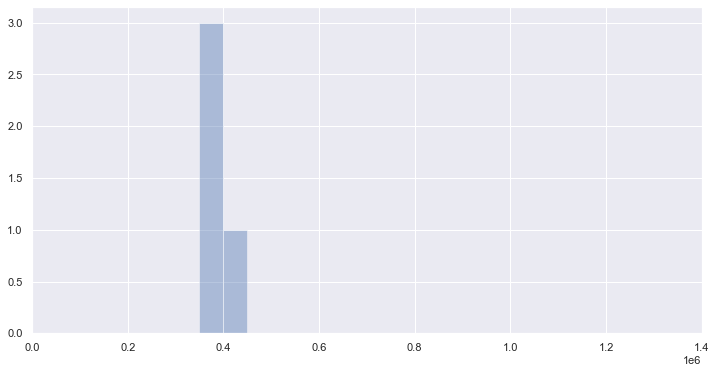

In [23]:
fig, ax = plt.subplots()
sns.distplot(x, kde=False, norm_hist=False)
ax.set_xlim(0,1400000)

# 7 Precio Promedio

In [25]:
sql = "select nombre_region, avg(precio) as precio_prom from vendedor join anuncio using (id_vendedor) where categoria=\"Arriendo - Departamento\" and moneda=\"$\" and nombre_region != \"Ñuble\" and precio < 1500000 group by nombre_region order by precio_prom DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1

,nombre_region,precio_prom
0,Metropolitana,420000.0000
1,Antofagasta,350000.0000
2,Tarapacá,350000.0000


In [26]:
df1["precio_prom"] = df1["precio_prom"].astype(int)
df1

,nombre_region,precio_prom
0,Metropolitana,420000
1,Antofagasta,350000
2,Tarapacá,350000


In [27]:
df1.loc[df1.nombre_region == "Metropolitana", "nombre_region"] = "Metropolitana de Santiago"
df1.loc[df1.nombre_region == "Valparaíso", "nombre_region"] = "Valparaiso"
df1.loc[df1.nombre_region == "Biobío", "nombre_region"] = "Biobio"
df1.loc[df1.nombre_region == "Magallanes & Antártica", "nombre_region"] = "Magallanes y de la Antartica Chileno"
df1.loc[df1.nombre_region == "Araucanía", "nombre_region"] = "La Araucania"
df1.loc[df1.nombre_region == "O'Higgins", "nombre_region"] = "Libertador Gral. Bernardo O'Higgins"
df1.loc[df1.nombre_region == "Los Ríos", "nombre_region"] = "Los Rios"
df1.loc[df1.nombre_region == "Tarapacá", "nombre_region"] = "Tarapaca"
df1.loc[df1.nombre_region == "Aisén", "nombre_region"] = "Aisen del Gral. Carlos Ibañez del Campo"
df1.loc[df1.nombre_region == "Arica & Parinacota", "nombre_region"] = "Arica y Parinacota"

In [28]:
import geopandas as gpd

df_geo = gpd.read_file(shp_path)

In [29]:
df_geo

,ID_2002,NOMBRE,geometry
0,15,Arica y Parinacota,"POLYGON ((-70.26623 -19.19022, -70.27196 -19.18892, -70.27457 -19.18345, -70.27760 -19.17672, -70.27403 -19.17129, -70.27533 -19.16751, -70.27352 -19.16249, -70.27084 -19.15789, -70.27079 -19.15119, -70.26988 -19.14784, -70.26985 -19.14364, -70.27904 -19.13351, -70.27900 -19.12890, -70.28513 -19..."
1,01,Tarapaca,"POLYGON ((-70.28617 -19.22897, -70.13096 -19.15446, -70.09897 -19.11888, -70.00240 -19.08001, -69.99822 -19.07553, -69.98297 -19.06716, -69.98058 -19.06447, -69.97789 -19.06327, -69.97519 -19.06536, -69.96353 -19.05969, -69.95636 -19.05341, -69.95217 -19.05042, -69.94560 -19.04892, -69.94111 -19..."
2,02,Antofagasta,"POLYGON ((-68.48122 -20.94599, -68.48081 -20.94435, -68.48143 -20.94149, -68.47836 -20.94087, -68.47651 -20.94435, -68.47447 -20.94681, -68.46546 -20.94599, -68.46014 -20.94415, -68.45461 -20.94578, -68.45236 -20.94578, -68.44867 -20.94681, -68.44581 -20.94496, -68.44151 -20.94558, -68.43885 -20..."
3,03,Atacama,"POLYGON ((-68.54489 -25.29883, -68.54386 -25.31049, -68.54530 -25.31193, -68.54427 -25.31459, -68.53731 -25.31971, -68.53527 -25.32175, -68.53383 -25.31950, -68.53035 -25.31950, -68.52462 -25.32646, -68.52176 -25.32830, -68.52114 -25.33363, -68.52114 -25.33792, -68.51909 -25.34018, -68.51889 -25..."
4,04,Coquimbo,"POLYGON ((-69.95231 -29.50337, -69.95157 -29.50454, -69.94912 -29.50698, -69.94815 -29.50943, -69.94815 -29.51065, -69.94717 -29.51163, -69.94692 -29.51383, -69.94741 -29.51505, -69.94717 -29.51945, -69.95010 -29.51994, -69.95108 -29.52140, -69.94912 -29.52336, -69.94888 -29.52580, -69.94961 -29..."
5,05,Valparaiso,"POLYGON ((-70.31980 -32.27473, -70.31443 -32.27449, -70.31320 -32.27449, -70.30710 -32.27669, -70.30294 -32.27644, -70.29805 -32.27742, -70.29488 -32.28157, -70.29341 -32.28377, -70.29390 -32.28671, -70.29121 -32.28817, -70.28779 -32.29013, -70.28584 -32.29208, -70.28193 -32.29330, -70.27582 -32..."
6,13,Metropolitana de Santiago,"POLYGON ((-70.24362 -33.18739, -70.24229 -33.18418, -70.24010 -33.17989, -70.23790 -33.17489, -70.23956 -33.17165, -70.23992 -33.16699, -70.23816 -33.16342, -70.23558 -33.16129, -70.23171 -33.15918, -70.22955 -33.15705, -70.22646 -33.14955, -70.22897 -33.14630, -70.23151 -33.14448, -70.23446 -33..."
7,06,Libertador Gral. Bernardo O'Higgins,"POLYGON ((-70.03126 -34.28848, -70.03171 -34.29233, -70.03025 -34.29624, -70.02854 -34.30015, -70.02169 -34.30797, -70.02218 -34.31066, -70.02121 -34.31603, -70.01779 -34.32483, -70.01876 -34.32727, -70.01583 -34.33118, -70.01436 -34.33973, -70.01730 -34.34218, -70.01827 -34.34560, -70.01950 -34..."
8,07,Maule,"POLYGON ((-70.36378 -35.00388, -70.36476 -35.00681, -70.36452 -35.00999, -70.36672 -35.01267, -70.36598 -35.01634, -70.36623 -35.01829, -70.36305 -35.01951, -70.36036 -35.02685, -70.36281 -35.03124, -70.36061 -35.03466, -70.36696 -35.03613, -70.37307 -35.04077, -70.37331 -35.04322, -70.37576 -35..."
9,08,Biobio,"MULTIPOLYGON (((-73.68449 -37.36724, -73.68413 -37.36630, -73.68358 -37.36530, -73.68225 -37.36463, -73.68141 -37.36388, -73.68129 -37.36341, -73.68185 -37.36299, -73.68153 -37.36261, -73.68103 -37.36255, -73.68015 -37.36258, -73.67962 -37.36205, -73.67938 -37.36142, -73.67933 -37.36055, -73.678..."


In [30]:
df1

,nombre_region,precio_prom
0,Metropolitana de Santiago,420000
1,Antofagasta,350000
2,Tarapaca,350000


In [31]:
result = pd.concat([df_geo.set_index("NOMBRE"), df1.set_index("nombre_region")], axis=1, join='inner')
result

,ID_2002,geometry,precio_prom
Tarapaca,01,"POLYGON ((-70.28617 -19.22897, -70.13096 -19.15446, -70.09897 -19.11888, -70.00240 -19.08001, -69.99822 -19.07553, -69.98297 -19.06716, -69.98058 -19.06447, -69.97789 -19.06327, -69.97519 -19.06536, -69.96353 -19.05969, -69.95636 -19.05341, -69.95217 -19.05042, -69.94560 -19.04892, -69.94111 -19...",350000
Antofagasta,02,"POLYGON ((-68.48122 -20.94599, -68.48081 -20.94435, -68.48143 -20.94149, -68.47836 -20.94087, -68.47651 -20.94435, -68.47447 -20.94681, -68.46546 -20.94599, -68.46014 -20.94415, -68.45461 -20.94578, -68.45236 -20.94578, -68.44867 -20.94681, -68.44581 -20.94496, -68.44151 -20.94558, -68.43885 -20...",350000
Metropolitana de Santiago,13,"POLYGON ((-70.24362 -33.18739, -70.24229 -33.18418, -70.24010 -33.17989, -70.23790 -33.17489, -70.23956 -33.17165, -70.23992 -33.16699, -70.23816 -33.16342, -70.23558 -33.16129, -70.23171 -33.15918, -70.22955 -33.15705, -70.22646 -33.14955, -70.22897 -33.14630, -70.23151 -33.14448, -70.23446 -33...",420000


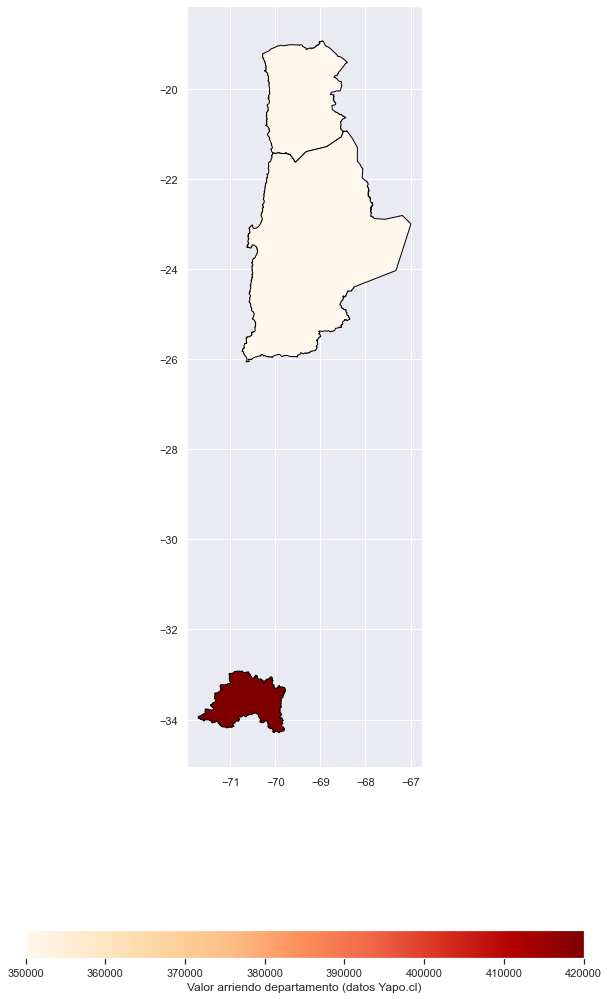

In [32]:
fig, ax = plt.subplots(figsize=(10,20))
result.plot(ax=ax,edgecolor='black',column='precio_prom', cmap='OrRd',legend=True,
        legend_kwds={'label': "Valor arriendo departamento (datos Yapo.cl)",'orientation': "horizontal"})
ax.set_aspect('equal')
plt.show()

# 8 10 Palabras Más Frecuentes

In [46]:
sql = "SELECT categoria, GROUP_CONCAT(descripcion SEPARATOR ' ') as concat_description FROM anuncio GROUP BY categoria;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1

,categoria,concat_description
0,Accesorios y piezas para vehículos,"radio para auto Aiwa sin uso, con bluethoot, usb, auxiliar, tarjeta, reproductor de cd, panel desmontable, cables para conectar, en $45000 algo tratable.La entrego probada. 2 llantas buenas de chetvrolet Montana una tiene el neumático nuevo casi (Michelin) la otra el neumático está malo las llan..."
1,Animales y sus accesorios,"inseparables rosicollis papilleros 25.000 c/u también vendo la papilla soy de la Florida disponibles estas dos conejas adultas, entan en venta por motivos de espacio, interesados enviar mensaje al +569 96700309"
2,Arriendo - Casa,"PROPIEDADES Ofrece en ARRIENDO Excelente casa Aislada ubicada en Villa Galilea, a pasos de plaza de armas de la comuna de Rengo, VI Región.La casa se encuentra en calle Principal y cuenta con living comedor por separado, cocina, 3 dormitorios, 2 baños (Principal en suite), sala de estar, etc.Dis..."
3,Arriendo - Comercial e industrial,casa con almacén o que se pueda acondicionar para negocio . 987251652
4,Arriendo - Departamento,"piso 5to, cercano Inacap, Centro comerciales, Supermercados, Agro sur, cuenta con vigilancia permanente y control de ingreso de vehículos Condiciones de arriendo Pago del mes más garantía Antecedentes a presentar (actualizado)Contrato de trabajoCertificado de antigüedad laboral Últimas 3 liquida..."
5,Arriendo - Pieza,"para persona sola .A pasos mall plaza vespucio, también a cuadras de distancia del mall florida center .ubicación privilegiada ,lado líder ,restaurant, institutos , hospital, clínica ,entre otros, excelente locomoción, a pasos de las 2 lineas del metro . Pieza con baño en suite , cama, closet..."
6,"Arte, antigüedades y colecciones","exclusivo rapido y furioso por $60.000 en piedra de la cultura mapuche hermosas piezas de coleccion años 50 de The Beatles marco de madera en excelente estado! 69x53 perro o extencion de radiador nueva año 30..31 de 12 lápices punta pincel, en base a agua. Tienen doble punta, pincel y fineliner..."
7,"Audio, TV, video y fotografía","Apple TV usado me compre un smart Tv y no lo ocupo está impecable hasta con su caja ( entrego en mi casa o villa alemana ( estafadores no perder su tiempo mediante envíos o transferencia) $40000 de musica,cd,radio,usb para mp3,control remoto,funcionando en excelentes condiciones Master G, pantal..."
8,"Autos, camionetas y 4x4","2.0 Automatico secuencial, petrolera, 3 corridas de asientos, radio pantalla con cámara retroceso, auxiliar, USB, Bluetooth, mirror, sunroof, amortiguadores Race tipo sport, 4x2 color blanco, papeles al día transferible. ford Ranger xlt americana año 1995, airbag piloto, pintada completa, tapiza..."
9,"Bicicletas, ciclismo y accesorios","Ninety-nine 3000 de carbono año 2017 aro 27,5 nueva. Más info al WhatsApp o por mensaje (me la pasaron en parte de pago por eso no tiene uso)"


In [88]:
#solo usando Counter
from collections import Counter

desc = df1.concat_description
cat = df1.categoria
c = 0
for i in desc:
    removeSpecialChars = i.translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,./<>?\|`~-=_+"})
    words = " ".join(removeSpecialChars.split()).split(" ")
    countWords = Counter(words)
    wpc = countWords.most_common(10)
    print(cat[c], ":\n", wpc[:], '\n')
    c += 1


Accesorios y piezas para vehículos :
 [('56974730797', 5), ('para', 4), ('wsap', 4), ('de', 3), ('el', 3), ('sin', 2), ('en', 2), ('entrego', 2), ('2', 2), ('llantas', 2)] 

Animales y sus accesorios :
 [('la', 2), ('de', 2), ('inseparables', 1), ('rosicollis', 1), ('papilleros', 1), ('25', 1), ('000', 1), ('c', 1), ('u', 1), ('también', 1)] 

Arriendo - Casa :
 [('en', 9), ('de', 8), ('y', 5), ('casa', 4), ('dormitorios', 4), ('2', 4), ('para', 4), ('con', 3), ('comedor', 3), ('cocina', 3)] 

Arriendo - Comercial e industrial :
 [('casa', 1), ('con', 1), ('almacén', 1), ('o', 1), ('que', 1), ('se', 1), ('pueda', 1), ('acondicionar', 1), ('para', 1), ('negocio', 1)] 

Arriendo - Departamento :
 [('de', 9), ('a', 5), ('con', 4), ('piso', 3), ('3', 3), ('2', 3), ('cercano', 2), ('y', 2), ('del', 2), ('dormitorios', 2)] 

Arriendo - Pieza :
 [('para', 5), ('de', 3), ('con', 3), ('los', 3), ('persona', 2), ('sola', 2), ('pasos', 2), ('mall', 2), ('a', 2), ('del', 2)] 

Arte, antigüedades y

In [37]:
!python3 -m spacy download es_core_news_sm

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [48]:
#Usando Spacy y Counter
import spacy
from collections import Counter

desc = df1.concat_description
cat = df1.categoria
c = 0
for i in desc:
    nlp = spacy.load('es_core_news_sm')
    doc = nlp(i)
    nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]
    
    word_freq = Counter(nouns)
    common_words = word_freq.most_common(10)
    print(cat[c], ":\n", common_words[:], '\n')
    c += 1


Accesorios y piezas para vehículos :
 [('llantas', 2), ('neumático', 2), ('techo', 2), ('radio', 1), ('auto', 1), ('tarjeta', 1), ('reproductor', 1), ('panel', 1), ('entrego', 1), ('chetvrolet', 1)] 

Animales y sus accesorios :
 [('papilla', 1), ('conejas', 1), ('venta', 1), ('motivos', 1), ('espacio', 1), ('mensaje', 1), ('96700309', 1)] 

Arriendo - Casa :
 [('casa', 4), ('dormitorios', 4), ('cocina', 3), ('living', 2), ('entrada', 2), ('pasos', 1), ('plaza', 1), ('armas', 1), ('comuna', 1), ('calle', 1)] 

Arriendo - Comercial e industrial :
 [('negocio', 1), ('987251652', 1)] 

Arriendo - Departamento :
 [('piso', 3), ('dormitorios', 2), ('baños', 2), ('vigilancia', 1), ('control', 1), ('ingreso', 1), ('vehículos', 1), ('mes', 1), ('garantía', 1), ('antigüedad', 1)] 

Arriendo - Pieza :
 [('persona', 2), ('pasos', 2), ('personas', 2), ('cuadras', 1), ('distancia', 1), ('.ubicación', 1), ('líder', 1), ('institutos', 1), ('locomoción', 1), ('lineas', 1)] 

Arte, antigüedades y colec

# 9 Palabra Más Frecuente Por Región

In [49]:
sql = "SELECT nombre_region, GROUP_CONCAT(descripcion SEPARATOR ' ') as concat_description FROM vendedor v JOIN anuncio a ON v.id_vendedor = a.id_vendedor GROUP BY nombre_region;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1

,nombre_region,concat_description
0,Aisén,"cabañas amobladas con 2 dormitorios, a 4 cuadras de Plaza Armas de Coyhaique.Cuenta con todo lo necesario para habitar.Enmarcada en pequeño condominio.Ideal para matrimonio solo sin hijos o profesionales solteros y/o para arrendar/compartir 2 personas.Tiene 2 dormitorios,cocina americana,living ..."
1,Antofagasta,"casa con almacén o que se pueda acondicionar para negocio . 987251652 Santa Beatriz, Coviefi, Altilhue, tiene3 dormitorios( 2 medianos, y 1 pequeño), 1 baño, balcon, estacionamiento y bodega.Condominio con conserjeria, buen sector residencial, sur.valor: 350.000 pesosse paga mes de arriendomes d..."
2,Araucanía,"venden dos Kit de bujes originales tren delantero Peugeot 505 marca sasic. NUEVOS.Se vende el PARWSP: +56962363490 CORREA DISTRIBUCIONChevrolet CorsaOpel Astra FDaewoo Lanos/HeavenREFERENCIA ORIGINAL / OEM904994019035317690570525920247891176955636722 disponibles estas dos conejas adultas, entan ..."
3,Arica & Parinacota,celular Hualla dactilar buena Cargador original y caja Cámaras buenas Desbloqueado Sin problemas Mate 20 Pro *128gb *6gb ram*Pantalla Oled QHD+ 6.39'*Procesador kirin 980 octa-core *Triple camara leica 40mp + 20mp + 8mp*Frontal selfie 24mp*parlantes stereo sonido Hifi*Lector de huellas en la...
4,Atacama,"río5, full equipo con llantas, aire acondicionado en buen estado, alza vidrio, cierre centralizado Manutenciones y papeles al día. TODO EN BUEN ESTADO kia rio5 full equipo con aire acondicionado, llantas de 8"
5,Biobío,"LED 1157 P21/5W-BAY15D COLOR ROJOEspecificaciones:Potencia: 4,08 WCorriente eléctrica: 0.36ATipo de enchufe: (1157-P21/5W-BAY15D)Cuentas de luz: superbrillo SMD 21*3030Brillo: 1000Lm por LuzÁngulo de iluminación: 360 gradosVida útil:> 50.000 horas de trabajoAplicación:Lámpara de señal de giro, ..."
6,Coquimbo,"renovación. En exelentes condiciones, cero fallas, varios extras ( llantas mono modelo strike2black, focos ojos de angel aleron, radio multimedia . Consultas al wsp +56956968694 vende suzuki Vendo Suzuki swift Modelo GLX FULL año 2018 único dueño solo 50.000 km Motor 1.2 súper económico y rápido..."
7,Los Lagos,"vende empaquetadura culata nueva, vehículo citroen 3 tercel año 97Ajuste de motor recien echoHay que cambiar soportes de motorDetalles por el añoPapeles atrasados este añoA mi nombre1.2millones conversableKilometraje del vehiculo 480.xxx Motor, caja y radiador impeque sin fugas, más detalles al ..."
8,Los Ríos,"dormitorios baño , cocina y comedor estilo americana importante entrada independiente asi como la casa encontramos en puyehue camino a los tayos a 5 kilómetros de Panguipulli.Fono contacto: 953175654 venden originales"
9,Magallanes & Antártica,"honda fit rs año 2008 motor 1.5 vtec automático secuencial cambios al volante caja séptima radio doble din pionner amplificador taramps 160x2 cajón con 2 bajos soundstrem doble bobina 800rms potencia máxima 2400watts c/u 2 amplificadores taramps de 400 rms c/u llantas force de 8"" cóncavas neumát..."


In [53]:
#solo usando Counter
desc = df1.concat_description
reg = df1.nombre_region
c = 0
for i in desc:
    removeSpecialChars = i.translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,./<>?\|`~-=_+"})
    words = " ".join(removeSpecialChars.split()).split(" ")
    countWords = Counter(words)
    wpc = countWords.most_common(5)
    print(reg[c], ":\n", wpc[0], '\n')
    c += 1

Aisén :
 ('con', 6) 

Antofagasta :
 ('de', 11) 

Araucanía :
 ('en', 9) 

Arica & Parinacota :
 ('de', 5) 

Atacama :
 ('full', 2) 

Biobío :
 ('de', 15) 

Coquimbo :
 ('al', 6) 

Los Lagos :
 ('vende', 4) 

Los Ríos :
 ('a', 2) 

Magallanes & Antártica :
 ('de', 7) 

Maule :
 ('de', 9) 

Metropolitana :
 ('DE', 7) 

O'Higgins :
 ('de', 5) 

Tarapacá :
 ('de', 8) 

Valparaíso :
 ('de', 12) 



In [50]:
#Usando Spacy y Counter

desc = df1.concat_description
reg = df1.nombre_region
c = 0
for i in desc:
    nlp = spacy.load('es_core_news_sm')
    doc = nlp(i)
    nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]
    
    word_freq = Counter(nouns)
    common_words = word_freq.most_common(3)
    print(reg[c], ":\n", common_words[0], '\n')
    c += 1


Aisén :
 ('dormitorios', 2) 

Antofagasta :
 ('precio', 3) 

Araucanía :
 ('bujes', 1) 

Arica & Parinacota :
 ('problemas', 1) 

Atacama :
 ('equipo', 2) 

Biobío :
 ('luz', 4) 

Coquimbo :
 ('entrego', 2) 

Los Lagos :
 ('años', 3) 

Los Ríos :
 ('dormitorios', 1) 

Magallanes & Antártica :
 ('motor', 1) 

Maule :
 ('agua', 2) 

Metropolitana :
 ('meses', 3) 

O'Higgins :
 ('luz', 4) 

Tarapacá :
 ('piso', 1) 

Valparaíso :
 ('llantas', 2) 



# 10  A partir de los datos disponibles en Yapo.cl, ¿qué escenario de análisis pueden proponer para analizar la actividad económica en Chile durante el periodo de Covid?

Se podría restringir las fechas de evaluación para antes de marzo para analizar la actividad antes del confinamiento en Chile y entre marzo y el presente para analizarlo durante. Se pueden comparar la cantidad de anuncios por categoria para estos dos períodos para evaluar que tipo de anuncios aumentaron en cantidad y cuáles disminuyeron. Además se pueden comparar el promedio de precios de cada categoría o elementos específicos para ver la variación de ellos antes y durante la pandemia. 